In [1]:
import argparse
import pickle
import os
import numpy as np
import tensorflow as tf
from datetime import datetime, date
from utils.model import create_model
from utils.webservice import getsize_h5model, log_write
from utils.data import create_dataframe, ImageGenerator, get_sample, config_batch
from sklearn.model_selection import train_test_split

from configs.server import MODEL_PATH, LOG_FILE, FLAG, HIST, NEED_CONFIRM
from configs.image import DATA_PATH
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [17]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [2]:
# model_name = 'Teachable_machine'
image_folder = 'new_data'
# num_epochs = 20
learning_rate = 0.001

In [3]:
# get number of classes (= number of subfolder)
training_path = os.path.join(DATA_PATH, image_folder)
classes = [name for name in os.listdir(training_path)
               if os.path.isdir(os.path.join(training_path, name))]
num_classes = len(classes)

In [4]:
classes

['LNG', 'LRNG', 'OK', 'RNG']

In [5]:
image_dataframe = create_dataframe(training_path, classes)

image_dataframe.head(4)

,Filepath,Classes,Label
0,data\new_data\LNG\20191206170048_WEQ6T12060028...,LNG,0
1,data\new_data\LNG\20191206170158_WEQ6T12060029...,LNG,0
2,data\new_data\LNG\20191206170908_WEQ6T12060035...,LNG,0
3,data\new_data\LNG\flip_20191206170048_WEQ6T120...,LNG,0


In [6]:
data_split = ['train', 'val']

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=6,
    brightness_range=(0.6, 0.8),
    width_shift_range=[0, 2, 5],
    fill_mode='constant',
    cval=0,
    )
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

image_generator = {'train': train_generator,
                   'val': test_generator}
train_frame, test_frame = train_test_split(image_dataframe, test_size=0.15, random_state=911)
dtframe = {'train': train_frame, 'val': test_frame}

aug_generator = {x: image_generator[x].flow_from_dataframe(dataframe=dtframe[x], 
                                                           x_col='Filepath',
                                                           y_col='Classes',
                                                           target_size=(224, 224),
                                                           class_model='categorical',
                                                           batch_size=8)
                 for x in data_split}

Found 312 validated image filenames belonging to 4 classes.
Found 56 validated image filenames belonging to 4 classes.


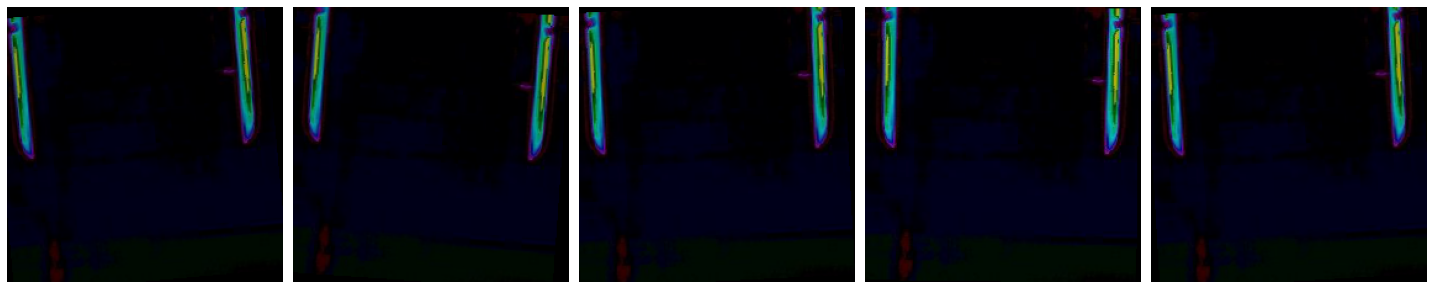

In [18]:
aug_images = [aug_generator['train'][0][0][0] for i in range(5)]
plot_images(aug_images)

In [8]:
nor_generator = {x: image_generator['val'].
                     flow_from_dataframe(dataframe=dtframe[x],
                                         x_col='Filepath',
                                         y_col='Classes',
                                         target_size=(224, 224),
                                         class_model='categorical',
                                         batch_size=8)
                 for x in data_split}

Found 312 validated image filenames belonging to 4 classes.
Found 56 validated image filenames belonging to 4 classes.


In [9]:
def scheduler(epoch):
    if epoch < 7:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Try teachable machine

In [10]:
aug_model = create_model('Teachable_machine', num_classes)
aug_history = aug_model.fit(x=aug_generator['train'],
                          validation_data=aug_generator['val'],
                          validation_freq=1,
                          epochs=30,
                          verbose=1, 
                          callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 7 steps
Epoch 1/30
39/39 [==============================] - 17s 444ms/step - loss: 0.6344 - accuracy: 0.7532 - val_loss: 1.9086 - val_accuracy: 0.6607
Epoch 2/30
39/39 [==============================] - 13s 324ms/step - loss: 0.2630 - accuracy: 0.9231 - val_loss: 1.9243 - val_accuracy: 0.6964
Epoch 3/30
39/39 [==============================] - 13s 332ms/step - loss: 0.1946 - accuracy: 0.9423 - val_loss: 2.1026 - val_accuracy: 0.6964
Epoch 4/30
39/39 [==============================] - 13s 342ms/step - loss: 0.1548 - accuracy: 0.9583 - val_loss: 1.9735 - val_accuracy: 0.7321
Epoch 5/30
39/39 [==============================] - 13s 331ms/step - loss: 0.1104 - accuracy: 0.9679 - val_loss: 1.9590 - val_accuracy: 0.5893
Epoch 6/30
39/39 [==============================] - 13s 326ms/step - loss: 0.0760 - accuracy: 0.9872 - val_loss: 2.1540 - val_accuracy: 0.7143
Epoch 7/30
39/39 [==============================] -

In [11]:
nor_model = create_model('Teachable_machine', num_classes)
nor_history = nor_model.fit(x=nor_generator['train'],
                          validation_data=nor_generator['val'],
                          validation_freq=1,
                          epochs=30,
                          verbose=1,
                          callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 7 steps
Epoch 1/30
39/39 [==============================] - 17s 448ms/step - loss: 0.4144 - accuracy: 0.8494 - val_loss: 1.2329 - val_accuracy: 0.6607
Epoch 2/30
39/39 [==============================] - 13s 340ms/step - loss: 0.1390 - accuracy: 0.9583 - val_loss: 1.6579 - val_accuracy: 0.6607
Epoch 3/30
39/39 [==============================] - 13s 332ms/step - loss: 0.0625 - accuracy: 0.9872 - val_loss: 1.5833 - val_accuracy: 0.6786
Epoch 4/30
39/39 [==============================] - 13s 329ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 1.4638 - val_accuracy: 0.6786
Epoch 5/30
39/39 [==============================] - 13s 335ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 1.5054 - val_accuracy: 0.6786
Epoch 6/30
39/39 [==============================] - 13s 334ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 1.3996 - val_accuracy: 0.7143
Epoch 7/30
39/39 [==============================] -

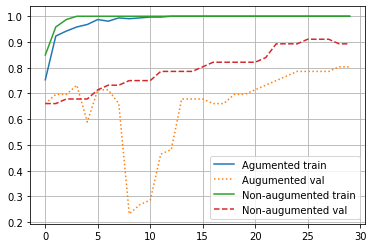

In [12]:
plt.plot(aug_history.history['accuracy'])
plt.plot(aug_history.history['val_accuracy'], linestyle=':')
plt.plot(nor_history.history['accuracy'])
plt.plot(nor_history.history['val_accuracy'], linestyle='--')
plt.legend(['Agumented train', 'Augumented val',
            'Non-augumented train', 'Non-augumented val'])
plt.grid()
plt.show()

# Note
### augumentation: 
#### 1. random rotate with angle random select in (-6, 6)
#### 2. random shift right or left with (0, 2, 7) pixel
#### 3. random increase brightness (increate each pixel by a random value in (0.6, 0.8)

# Try with simple model

In [20]:
aug_simple_model = create_model('Simple', num_classes)
aug_simple_history = aug_simple_model.fit(x=aug_generator['train'],
                          validation_data=aug_generator['val'],
                          validation_freq=1,
                          epochs=30,
                          verbose=1, 
                          callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 7 steps
Epoch 1/30
39/39 [==============================] - 7s 178ms/step - loss: 0.9375 - accuracy: 0.6122 - val_loss: 1.3437 - val_accuracy: 0.4643
Epoch 2/30
39/39 [==============================] - 6s 160ms/step - loss: 0.6696 - accuracy: 0.7628 - val_loss: 1.3483 - val_accuracy: 0.2321
Epoch 3/30
39/39 [==============================] - 6s 162ms/step - loss: 0.5864 - accuracy: 0.7724 - val_loss: 1.3021 - val_accuracy: 0.4464
Epoch 4/30
39/39 [==============================] - 6s 162ms/step - loss: 0.5318 - accuracy: 0.7756 - val_loss: 1.1887 - val_accuracy: 0.5893
Epoch 5/30
39/39 [==============================] - 6s 161ms/step - loss: 0.4994 - accuracy: 0.7724 - val_loss: 1.0441 - val_accuracy: 0.6429
Epoch 6/30
39/39 [==============================] - 6s 161ms/step - loss: 0.4875 - accuracy: 0.8077 - val_loss: 0.8956 - val_accuracy: 0.6607
Epoch 7/30
39/39 [==============================] - 6s 16

In [21]:
nor_simple_model = create_model('Teachable_machine', num_classes)
nor_simple_history = nor_simple_model.fit(x=nor_generator['train'],
                          validation_data=nor_generator['val'],
                          validation_freq=1,
                          epochs=30,
                          verbose=1,
                          callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 7 steps
Epoch 1/30
39/39 [==============================] - 17s 444ms/step - loss: 0.5303 - accuracy: 0.7981 - val_loss: 1.3032 - val_accuracy: 0.6607
Epoch 2/30
39/39 [==============================] - 13s 325ms/step - loss: 0.1420 - accuracy: 0.9519 - val_loss: 1.4993 - val_accuracy: 0.6607
Epoch 3/30
39/39 [==============================] - 13s 327ms/step - loss: 0.0676 - accuracy: 0.9904 - val_loss: 1.5478 - val_accuracy: 0.6607
Epoch 4/30
39/39 [==============================] - 13s 321ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 1.7218 - val_accuracy: 0.6786
Epoch 5/30
39/39 [==============================] - 13s 326ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 1.6874 - val_accuracy: 0.6786
Epoch 6/30
39/39 [==============================] - 13s 342ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.7084 - val_accuracy: 0.6964
Epoch 7/30
39/39 [==============================] -

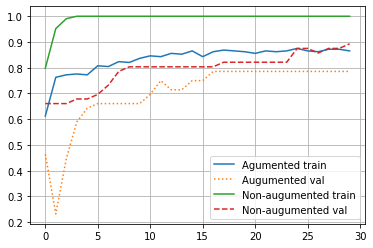

In [22]:
plt.plot(aug_simple_history.history['accuracy'])
plt.plot(aug_simple_history.history['val_accuracy'], linestyle=':')
plt.plot(nor_simple_history.history['accuracy'])
plt.plot(nor_simple_history.history['val_accuracy'], linestyle='--')
plt.legend(['Agumented train', 'Augumented val',
            'Non-augumented train', 'Non-augumented val'])
plt.grid()
plt.show()